In [184]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

In [185]:
data_dir = Path("./data")
db_path = data_dir / "hdb_prices.db"

conn = sqlite3.connect(db_path)
resale_df = pd.read_sql("SELECT * FROM resale_prices", conn)
conn.close()

In [186]:
resale_df.columns

Index(['_id', 'month', 'town', 'flat_type', 'flat_model', 'block',
       'street_name', 'storey_range', 'floor_area_sqm', 'lease_commence_date',
       'resale_price'],
      dtype='object')

In [187]:
resale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960898 entries, 0 to 960897
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _id                  960898 non-null  int64  
 1   month                960898 non-null  object 
 2   town                 960898 non-null  object 
 3   flat_type            960898 non-null  object 
 4   flat_model           960898 non-null  object 
 5   block                960898 non-null  object 
 6   street_name          960898 non-null  object 
 7   storey_range         960898 non-null  object 
 8   floor_area_sqm       960898 non-null  float64
 9   lease_commence_date  960898 non-null  object 
 10  resale_price         960898 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 80.6+ MB


In [188]:
resale_df.describe()

,_id,floor_area_sqm,resale_price
count,960898.000000,960898.000000,9.608980e+05
mean,480449.500000,95.668753,3.319208e+05
std,277387.503819,25.762875,1.811660e+05
min,1.000000,28.000000,5.000000e+03
25%,240225.250000,73.000000,1.980000e+05
50%,480449.500000,93.000000,3.050000e+05
75%,720673.750000,113.000000,4.300000e+05
max,960898.000000,366.700000,1.658888e+06


### Created Features
- time since lease commence date (may not be very accurate)
- years ago (numeric)
    - many years ago leads to cheaper price (so auto input this years date in the system prompt for prediction)
- month (categorical) 
    - different time of the month results in different prices ?? 


- age of flat
- remaining lease (99 - age)

In [189]:
## ideally can be used to get distance from public_trasport/ammenitites but too time consuming and rate limited
drop_cols = ["_id", "block", "street_name"] 

resale_df = resale_df.drop(columns=drop_cols, errors="ignore")
resale_df.head()

,month,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price
0,2012-03,ang mo kio,2-room,improved,06 to 10,45.0,1986,250000.0
1,2012-03,ang mo kio,2-room,improved,01 to 05,44.0,1980,265000.0
2,2012-03,ang mo kio,3-room,new generation,06 to 10,68.0,1980,315000.0
3,2012-03,ang mo kio,3-room,new generation,01 to 05,67.0,1984,320000.0
4,2012-03,ang mo kio,3-room,new generation,06 to 10,67.0,1980,321000.0


In [190]:
resale_df.sort_values("lease_commence_date")

,month,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price
20615,2013-01,jurong east,3-room,improved,01 to 03,67.0,1966,315000.0
233376,2005-06,jurong east,3-room,improved,04 to 06,67.0,1966,120000.0
601830,2024-05,jurong east,3-room,improved,01 to 03,67.0,1966,340000.0
479026,2019-09,jurong east,3-room,improved,01 to 03,67.0,1966,220000.0
395187,2010-12,jurong east,3-room,improved,01 to 03,67.0,1966,187000.0
...,...,...,...,...,...,...,...,...
624840,2025-06,hougang,4-room,model a,10 to 12,93.0,2021,688000.0
630593,2025-04,sengkang,4-room,model a,13 to 15,93.0,2021,690888.0
629191,2025-06,queenstown,3-room,premium apartment,25 to 27,63.0,2022,790000.0
629058,2025-06,queenstown,2-room,premium apartment,25 to 27,47.0,2022,540000.0


In [191]:
resale_df['lease_commence_date'] = pd.to_datetime(resale_df['lease_commence_date'], format='%Y')
resale_df['month'] = pd.to_datetime(resale_df['month'], format='%Y-%m')

#### Year and month of transaction

In [192]:
resale_df['year_of_transact'] = resale_df['month'].dt.year
resale_df['month_of_transact'] = resale_df['month'].dt.month
resale_df = resale_df.drop('month', axis=1)
resale_df.head()

,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price,year_of_transact,month_of_transact
0,ang mo kio,2-room,improved,06 to 10,45.0,1986-01-01,250000.0,2012,3
1,ang mo kio,2-room,improved,01 to 05,44.0,1980-01-01,265000.0,2012,3
2,ang mo kio,3-room,new generation,06 to 10,68.0,1980-01-01,315000.0,2012,3
3,ang mo kio,3-room,new generation,01 to 05,67.0,1984-01-01,320000.0,2012,3
4,ang mo kio,3-room,new generation,06 to 10,67.0,1980-01-01,321000.0,2012,3


#### Time since lease commence date
- proxy since we do not have the land lease tenures

In [193]:
resale_df['years_between_lease_and_sale'] = (resale_df['year_of_transact'] - resale_df['lease_commence_date'].dt.year)
resale_df.head()

,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price,year_of_transact,month_of_transact,years_between_lease_and_sale
0,ang mo kio,2-room,improved,06 to 10,45.0,1986-01-01,250000.0,2012,3,26
1,ang mo kio,2-room,improved,01 to 05,44.0,1980-01-01,265000.0,2012,3,32
2,ang mo kio,3-room,new generation,06 to 10,68.0,1980-01-01,315000.0,2012,3,32
3,ang mo kio,3-room,new generation,01 to 05,67.0,1984-01-01,320000.0,2012,3,28
4,ang mo kio,3-room,new generation,06 to 10,67.0,1980-01-01,321000.0,2012,3,32


#### Age of flat

In [194]:
resale_df['age_of_flat'] = (
    pd.to_datetime(resale_df['lease_commence_date'], errors='coerce').dt.year - pd.to_datetime(resale_df['year_of_transact'], errors='coerce').dt.year
    )

resale_df.head()

,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price,year_of_transact,month_of_transact,years_between_lease_and_sale,age_of_flat
0,ang mo kio,2-room,improved,06 to 10,45.0,1986-01-01,250000.0,2012,3,26,16
1,ang mo kio,2-room,improved,01 to 05,44.0,1980-01-01,265000.0,2012,3,32,10
2,ang mo kio,3-room,new generation,06 to 10,68.0,1980-01-01,315000.0,2012,3,32,10
3,ang mo kio,3-room,new generation,01 to 05,67.0,1984-01-01,320000.0,2012,3,28,14
4,ang mo kio,3-room,new generation,06 to 10,67.0,1980-01-01,321000.0,2012,3,32,10


#### Remaining lease

In [195]:
resale_df['remaining_lease'] = 99 - resale_df["age_of_flat"]

resale_df.head()

,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price,year_of_transact,month_of_transact,years_between_lease_and_sale,age_of_flat,remaining_lease
0,ang mo kio,2-room,improved,06 to 10,45.0,1986-01-01,250000.0,2012,3,26,16,83
1,ang mo kio,2-room,improved,01 to 05,44.0,1980-01-01,265000.0,2012,3,32,10,89
2,ang mo kio,3-room,new generation,06 to 10,68.0,1980-01-01,315000.0,2012,3,32,10,89
3,ang mo kio,3-room,new generation,01 to 05,67.0,1984-01-01,320000.0,2012,3,28,14,85
4,ang mo kio,3-room,new generation,06 to 10,67.0,1980-01-01,321000.0,2012,3,32,10,89


### Categorical variables that affect price
- flat_type
- town
- storey_range
- flat_model

#### storey range

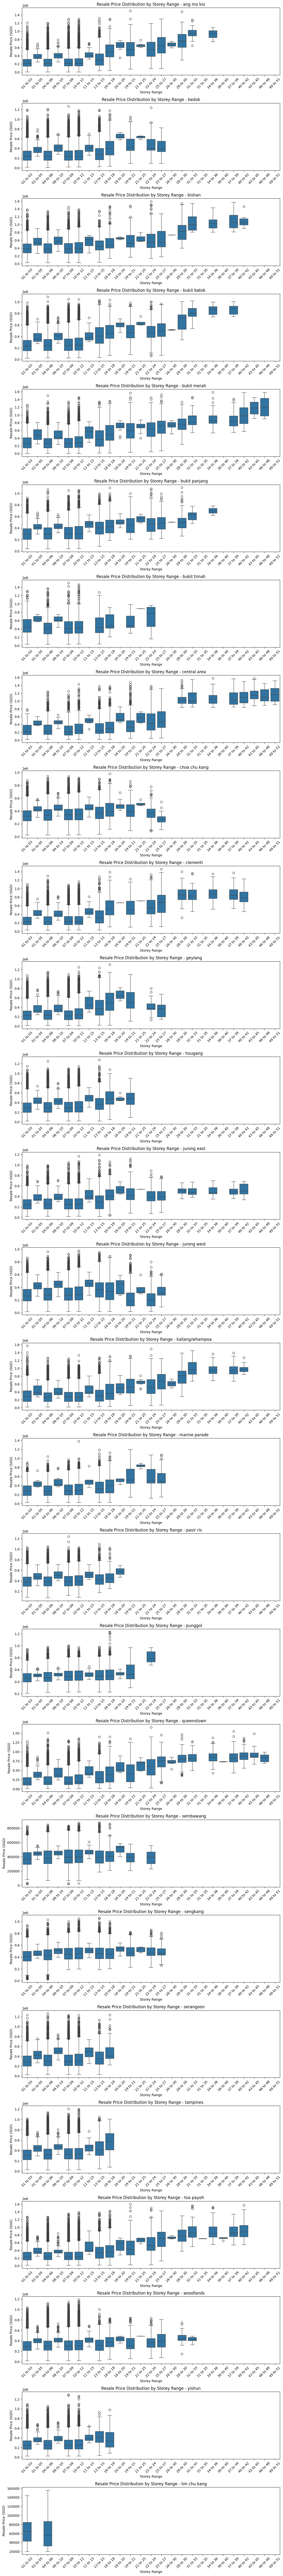

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure storey_range is treated as a category
resale_df["storey_range"] = resale_df["storey_range"].astype("category")

# Get unique towns since maybe location determines the height of the hdbs
towns = resale_df['town'].unique()

# Create subplots for each town
fig, axes = plt.subplots(nrows=len(towns), ncols=1, figsize=(12, 4*len(towns)))

# Handle single subplot case
if len(towns) == 1:
    axes = [axes]

# Plot for each town
for i, town in enumerate(towns):
    town_data = resale_df[resale_df['town'] == town]
    sns.boxplot(data=town_data, x="storey_range", y="resale_price", ax=axes[i])
    axes[i].set_title(f"Resale Price Distribution by Storey Range - {town}")
    axes[i].set_xlabel("Storey Range")
    axes[i].set_ylabel("Resale Price (SGD)")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### One hot encode

In [197]:
resale_df.columns

Index(['town', 'flat_type', 'flat_model', 'storey_range', 'floor_area_sqm',
       'lease_commence_date', 'resale_price', 'year_of_transact',
       'month_of_transact', 'years_between_lease_and_sale', 'age_of_flat',
       'remaining_lease'],
      dtype='object')

In [198]:
resale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960898 entries, 0 to 960897
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   town                          960898 non-null  object        
 1   flat_type                     960898 non-null  object        
 2   flat_model                    960898 non-null  object        
 3   storey_range                  960898 non-null  category      
 4   floor_area_sqm                960898 non-null  float64       
 5   lease_commence_date           960898 non-null  datetime64[ns]
 6   resale_price                  960898 non-null  float64       
 7   year_of_transact              960898 non-null  int32         
 8   month_of_transact             960898 non-null  int32         
 9   years_between_lease_and_sale  960898 non-null  int32         
 10  age_of_flat                   960898 non-null  int32         
 11  remaining_lea

In [199]:
resale_df["lease_commence_date"] = resale_df["lease_commence_date"].dt.year.astype("Int64")

resale_df.head()

,town,flat_type,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price,year_of_transact,month_of_transact,years_between_lease_and_sale,age_of_flat,remaining_lease
0,ang mo kio,2-room,improved,06 to 10,45.0,1986,250000.0,2012,3,26,16,83
1,ang mo kio,2-room,improved,01 to 05,44.0,1980,265000.0,2012,3,32,10,89
2,ang mo kio,3-room,new generation,06 to 10,68.0,1980,315000.0,2012,3,32,10,89
3,ang mo kio,3-room,new generation,01 to 05,67.0,1984,320000.0,2012,3,28,14,85
4,ang mo kio,3-room,new generation,06 to 10,67.0,1980,321000.0,2012,3,32,10,89


In [200]:
cols = [
    "town",
    "flat_type",
    "flat_model",
    "storey_range",    
]

dummies = pd.get_dummies(
    resale_df[cols],
    columns=cols,
    prefix=cols,       # keeps original column names in the new dummy names
    drop_first=True   # keep all levels; flip to True to drop one level
)

resale_df = pd.concat([resale_df, dummies], axis=1)

# drop the original categorical columns
resale_df.drop(columns=cols, inplace=True)

resale_df.head()

,floor_area_sqm,lease_commence_date,resale_price,year_of_transact,month_of_transact,years_between_lease_and_sale,age_of_flat,remaining_lease,town_bedok,town_bishan,...,storey_range_28 to 30,storey_range_31 to 33,storey_range_31 to 35,storey_range_34 to 36,storey_range_36 to 40,storey_range_37 to 39,storey_range_40 to 42,storey_range_43 to 45,storey_range_46 to 48,storey_range_49 to 51
0,45.0,1986,250000.0,2012,3,26,16,83,False,False,...,False,False,False,False,False,False,False,False,False,False
1,44.0,1980,265000.0,2012,3,32,10,89,False,False,...,False,False,False,False,False,False,False,False,False,False
2,68.0,1980,315000.0,2012,3,32,10,89,False,False,...,False,False,False,False,False,False,False,False,False,False
3,67.0,1984,320000.0,2012,3,28,14,85,False,False,...,False,False,False,False,False,False,False,False,False,False
4,67.0,1980,321000.0,2012,3,32,10,89,False,False,...,False,False,False,False,False,False,False,False,False,False


In [201]:
resale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960898 entries, 0 to 960897
Data columns (total 85 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   floor_area_sqm                     960898 non-null  float64
 1   lease_commence_date                960898 non-null  Int64  
 2   resale_price                       960898 non-null  float64
 3   year_of_transact                   960898 non-null  int32  
 4   month_of_transact                  960898 non-null  int32  
 5   years_between_lease_and_sale       960898 non-null  int32  
 6   age_of_flat                        960898 non-null  int32  
 7   remaining_lease                    960898 non-null  int32  
 8   town_bedok                         960898 non-null  bool   
 9   town_bishan                        960898 non-null  bool   
 10  town_bukit batok                   960898 non-null  bool   
 11  town_bukit merah                   9608

### Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

RANDOM_STATE = 42
target_col = "resale_price"

# --- SAMPLE 100K ROWS ---
resale_df_sampled = resale_df.sample(n=250_000, random_state=RANDOM_STATE)

X = resale_df_sampled.drop(columns=[target_col])
y = resale_df_sampled[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

# identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns

# preprocess features
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_cols)],
    remainder="passthrough"
)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [203]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import joblib

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
    }

    model = XGBRegressor(**params)

    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("reg", model)
    ])

    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [204]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-08-29 06:44:25,474] A new study created in memory with name: no-name-315e1c71-90da-4e19-9b7c-10f2b4087a60


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-29 06:44:42,202] Trial 0 finished with value: 38572.082485598075 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.020514631117060235, 'subsample': 0.5399134897457754, 'colsample_bytree': 0.9874370403673366, 'gamma': 1.774438106993711, 'reg_alpha': 0.8454119367650248, 'reg_lambda': 5.014168933962341, 'min_child_weight': 7}. Best is trial 0 with value: 38572.082485598075.
[I 2025-08-29 06:44:49,417] Trial 1 finished with value: 143906.2790337531 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.0022258999796619197, 'subsample': 0.8692621262120089, 'colsample_bytree': 0.8086774501667244, 'gamma': 4.718879154219733, 'reg_alpha': 6.028079715171211, 'reg_lambda': 7.082240050660448, 'min_child_weight': 10}. Best is trial 0 with value: 38572.082485598075.
[I 2025-08-29 06:45:09,330] Trial 2 finished with value: 29961.521248169247 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.07580285499568114, 'subsample': 0.8

In [205]:
best_params = {**study.best_params, "random_state": RANDOM_STATE, "n_jobs": -1}
best_model = XGBRegressor(**best_params)

best_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("reg", best_model)
])

best_pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [206]:
save_dir = "model"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "xgb_tuned.joblib")
joblib.dump(best_pipe, model_path)

print(f"Model saved to: {model_path}")

Model saved to: model/xgb_tuned.joblib


In [207]:
expected_raw = best_pipe.named_steps["prep"].feature_names_in_
print("Pipeline expects these raw columns (order matters!):")
print(list(expected_raw))

Pipeline expects these raw columns (order matters!):
['floor_area_sqm', 'lease_commence_date', 'year_of_transact', 'month_of_transact', 'years_between_lease_and_sale', 'age_of_flat', 'remaining_lease', 'town_bedok', 'town_bishan', 'town_bukit batok', 'town_bukit merah', 'town_bukit panjang', 'town_bukit timah', 'town_central area', 'town_choa chu kang', 'town_clementi', 'town_geylang', 'town_hougang', 'town_jurong east', 'town_jurong west', 'town_kallang/whampoa', 'town_lim chu kang', 'town_marine parade', 'town_pasir ris', 'town_punggol', 'town_queenstown', 'town_sembawang', 'town_sengkang', 'town_serangoon', 'town_tampines', 'town_toa payoh', 'town_woodlands', 'town_yishun', 'flat_type_2-room', 'flat_type_3-room', 'flat_type_4-room', 'flat_type_5-room', 'flat_type_executive', 'flat_type_multi generation', 'flat_type_multi-generation', 'flat_model_3gen', 'flat_model_adjoined flat', 'flat_model_apartment', 'flat_model_dbss', 'flat_model_improved', 'flat_model_improved-maisonette', 'fla

In [208]:
def preprocess(variables: dict):
    """
    Preprocesses input variables for model prediction.
    
    Parameters:
        variables : dict
            Dictionary containing:
                - month: str, transaction month in format 'YYYY-MM'
                - town: str, name of the town
                - flat_type: str, type of flat
                - storey_range: str, range of storeys
                - floor_area_sqm: float, floor area in square meters
                - flat_model: str, model of the flat
                - lease_commence_date: str or int, year when lease commenced (e.g., '1990' or 1990)
    Returns:
        dict: Encoded dictionary ready for model prediction
    """
    # Convert input dict to DataFrame
    df = pd.DataFrame([variables])

    # Convert data types
    df['lease_commence_date'] = pd.to_datetime(df['lease_commence_date'], format='%Y')
    df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

    # Extract year and month of transaction
    df['year_of_transact'] = df['month'].dt.year
    df['month_of_transact'] = df['month'].dt.month

    # Drop original 'month' column as we have extracted its components
    df = df.drop('month', axis=1)

    # Calculate years between lease commencement and sale
    df['years_between_lease_and_sale'] = (
        df['year_of_transact'] - df['lease_commence_date'].dt.year
    )

    # Calculate age of flat and remaining lease
    df['age_of_flat'] = df['years_between_lease_and_sale']
    df['remaining_lease'] = 99 - df['age_of_flat']

    df["lease_commence_date"] = df["lease_commence_date"].dt.year.astype("Int64")

    # Define categorical columns to encode
    categorical_cols = ['town', 'flat_type', 'flat_model', 'storey_range']

    # One-hot encode categorical variables
    dummies = pd.get_dummies(
        df[categorical_cols],
        columns=categorical_cols,
        prefix=categorical_cols,
        drop_first=True
    )

    # Concatenate dummy variables with main dataframe
    df = pd.concat([df, dummies], axis=1)

    # Drop original categorical columns
    df = df.drop(columns=categorical_cols)

    # Optional: Reindex to match the exact column order from training (replace with actual expected columns)
    expected_columns = ['floor_area_sqm', 'lease_commence_date', 'year_of_transact', 'month_of_transact', 'years_between_lease_and_sale', 'age_of_flat', 'remaining_lease', 'per_square_meter', 'town_bedok', 'town_bishan', 'town_bukit batok', 'town_bukit merah', 'town_bukit panjang', 'town_bukit timah', 'town_central area', 'town_choa chu kang', 'town_clementi', 'town_geylang', 'town_hougang', 'town_jurong east', 'town_jurong west', 'town_kallang/whampoa', 'town_lim chu kang', 'town_marine parade', 'town_pasir ris', 'town_punggol', 'town_queenstown', 'town_sembawang', 'town_sengkang', 'town_serangoon', 'town_tampines', 'town_toa payoh', 'town_woodlands', 'town_yishun', 'flat_type_2-room', 'flat_type_3-room', 'flat_type_4-room', 'flat_type_5-room', 'flat_type_executive', 'flat_type_multi generation', 'flat_type_multi-generation', 'flat_model_3gen', 'flat_model_adjoined flat', 'flat_model_apartment', 'flat_model_dbss', 'flat_model_improved', 'flat_model_improved-maisonette', 'flat_model_maisonette', 'flat_model_model a', 'flat_model_model a-maisonette', 'flat_model_model a2', 'flat_model_multi generation', 'flat_model_new generation', 'flat_model_premium apartment', 'flat_model_premium apartment loft', 'flat_model_premium maisonette', 'flat_model_simplified', 'flat_model_standard', 'flat_model_terrace', 'flat_model_type s1', 'flat_model_type s2', 'storey_range_01 to 05', 'storey_range_04 to 06', 'storey_range_06 to 10', 'storey_range_07 to 09', 'storey_range_10 to 12', 'storey_range_11 to 15', 'storey_range_13 to 15', 'storey_range_16 to 18', 'storey_range_16 to 20', 'storey_range_19 to 21', 'storey_range_21 to 25', 'storey_range_22 to 24', 'storey_range_25 to 27', 'storey_range_26 to 30', 'storey_range_28 to 30', 'storey_range_31 to 33', 'storey_range_31 to 35', 'storey_range_34 to 36', 'storey_range_36 to 40', 'storey_range_37 to 39', 'storey_range_40 to 42', 'storey_range_43 to 45', 'storey_range_46 to 48', 'storey_range_49 to 51']

    # Reindex using expected columns, filling missing ones with 0
    df = df.reindex(columns=expected_columns, fill_value=0)

    # Return as dictionary (for JSON-like payload)
    return df.iloc[0].to_dict()

In [209]:
sample = {
  "month": "2025-01",
  "town": "ang mo kio",
  "flat_type": "4-room",
  "flat_model": "improved",
  "storey_range": "10 to 12",
  "floor_area_sqm": 90,
  "lease_commence_date": 2025
}

payload = preprocess(sample)

In [210]:
import joblib
import pandas as pd

# Load your trained model
model = joblib.load('model/xgb_tuned.joblib')

# Your sample payload
payload = {
    "month": "2025-01",
    "town": "ang mo kio",
    "flat_type": "4-room",
    "flat_model": "improved",
    "storey_range": "10 to 12",
    "floor_area_sqm": 90,
    "lease_commence_date": 2025
}

# Preprocess the payload
processed_data = preprocess(payload)  # Your existing preprocess function

# Convert to DataFrame for prediction
X_pred = pd.DataFrame([processed_data])

# Make prediction
prediction = model.predict(X_pred)[0]
print(f"Predicted resale price: ${prediction:,.2f}")

Predicted resale price: $623,925.19
